In [1]:
get_ipython().system('pip install xgboost')

import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import psycopg2
import pandas as pd



In [3]:
!pip install dotenv

import os
from dotenv import load_dotenv
import psycopg2
import pandas as pd

# --- Load environment variables ---
load_dotenv()

# --- Connect to PostgreSQL using env vars ---
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
df = pd.read_sql("SELECT * FROM bike_features;", conn)
conn.close()

# --- Drop rows with NULL target ---
df = df.dropna(subset=['needs_maintenance'])

# --- Feature Engineering (optional but improves accuracy) ---
df['vibration_per_km'] = df['avg_vibration_last_10_rides'] / (df['total_km_since_last_maintenance']+1)
df['rain_ratio'] = df['num_rides_in_rain_last_30_days'] / (df['days_since_last_serviced']+1)

# --- Features & Target ---
features = ['avg_vibration_last_10_rides',
            'total_km_since_last_maintenance',
            'num_rides_in_rain_last_30_days',
            'days_since_last_serviced',
            'vibration_per_km',
            'rain_ratio']

X = df[features]
y = df['needs_maintenance'].astype(int)

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)

   ---------------------------------------- 2/2 [dotenv]



C:\Users\Aditya\AppData\Local\Temp\ipykernel_20528\3302872140.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM bike_features;", conn)


In [4]:
#Training

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

# Split your data first (if you haven't already)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Train the model on resampled data
model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    min_child_weight=3,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y[y==0])/len(y[y==1]),
    random_state=42,
    eval_metric='logloss'
)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.79      0.79      0.79        24

    accuracy                           0.82        56
   macro avg       0.82      0.82      0.82        56
weighted avg       0.82      0.82      0.82        56



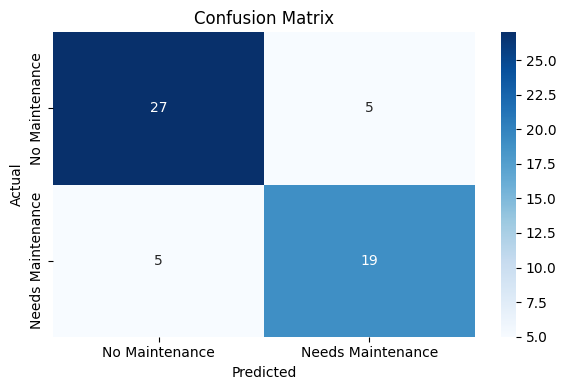

In [6]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Maintenance', 'Needs Maintenance'],
            yticklabels=['No Maintenance', 'Needs Maintenance'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [7]:
print(y_train.value_counts())


needs_maintenance
0    122
1    102
Name: count, dtype: int64


In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
print("Average F1 (5-fold):", scores.mean())


Average F1 (5-fold): 0.6264148809250667


In [9]:
model.save_model("xgb_bike_model.json")